In [23]:
from skimage import io,transform
import glob
import os
import tensorflow as tf
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
%matplotlib inline

path='/root/a_lilei/color/color/'

#将所有的图片resize成100*100
w=100
h=100
c=3


#读取图片
def read_img(path):
    cate=[path+x for x in os.listdir(path) if os.path.isdir(path+x)]
    imgs=[]
    labels=[]
    for idx,folder in enumerate(cate):
        for im in glob.glob(folder+'/*.jpg'):
            print('reading the images:%s'%(im))
            img=io.imread(im)
            img=transform.resize(img,(w,h))
            imgs.append(img)
            labels.append(idx)
    return np.asarray(imgs,np.float32),np.asarray(labels,np.int32)
data,label=read_img(path)


#打乱顺序
num_example=data.shape[0]
arr=np.arange(num_example)
np.random.shuffle(arr)
data=data[arr]
label=label[arr]


#将所有数据分为训练集和验证集
ratio=0.8
s=np.int(num_example*ratio)
x_train=data[:s]
y_train=label[:s]
x_val=data[s:]
y_val=label[s:]


#-----------------构建网络----------------------
#占位符
x=tf.placeholder(tf.float32,shape=[None,w,h,c],name='x')
y_=tf.placeholder(tf.int32,shape=[None,],name='y_')

#第一个卷积层（100——>50)
conv1=tf.layers.conv2d(
      inputs=x,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu,
      kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
pool1=tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

#第二个卷积层(50->25)
conv2=tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu,
      kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
pool2=tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

#第三个卷积层(25->12)
conv3=tf.layers.conv2d(
      inputs=pool2,
      filters=128,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
pool3=tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

#第四个卷积层(12->6)
conv4=tf.layers.conv2d(
      inputs=pool3,
      filters=128,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
pool4=tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)

re1 = tf.reshape(pool4, [-1, 6 * 6 * 128])

#全连接层
dense1 = tf.layers.dense(inputs=re1, 
                      units=1024, 
                      activation=tf.nn.relu,
                      kernel_initializer=tf.truncated_normal_initializer(stddev=0.01),
                      kernel_regularizer=tf.contrib.layers.l2_regularizer(0.003))
dense2= tf.layers.dense(inputs=dense1, 
                      units=512, 
                      activation=tf.nn.relu,
                      kernel_initializer=tf.truncated_normal_initializer(stddev=0.01),
                      kernel_regularizer=tf.contrib.layers.l2_regularizer(0.003))
logits= tf.layers.dense(inputs=dense2, 
                        units=5, 
                        activation=None,
                        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01),
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(0.003))
#---------------------------网络结束---------------------------

loss=tf.losses.sparse_softmax_cross_entropy(labels=y_,logits=logits)
train_op=tf.train.AdamOptimizer(learning_rate=0.000001).minimize(loss)
correct_prediction = tf.equal(tf.cast(tf.argmax(logits,1),tf.int32), y_)    
acc= tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


#定义一个函数，按批次取数据
def minibatches(inputs=None, targets=None, batch_size=None, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
        yield inputs[excerpt], targets[excerpt]


#训练和测试数据，可将n_epoch设置更大一些
params=tf.trainable_variables()
n_epoch=300 
batch_size=64
n_sample=25   #抽取样本数
samples=[]  #存储测试样例
sess=tf.InteractiveSession()  
sess.run(tf.global_variables_initializer())
# losses=[]
# accuracy=[]
saver=tf.train.Saver(max_to_keep=5)
max_acc=0
f=open('/root/a_lilei/model/tensorflow/ckpt/acc.txt','w')
fig_loss1=np.zeros([n_epoch])
fig_loss2=np.zeros([n_epoch])
fig_acc1=np.zeros([n_epoch])
fig_acc2=np.zeros([n_epoch])
for epoch in range(n_epoch):
    start_time = time.time()
    
    #training
    train_loss, train_acc, n_batch = 0, 0, 0
    for x_train_a, y_train_a in minibatches(x_train, y_train, batch_size, shuffle=True):
        _,err,ac=sess.run([train_op,loss,acc], feed_dict={x: x_train_a, y_: y_train_a})
        train_loss += err; train_acc += ac; n_batch += 1
    t_loss=train_loss/n_batch
    t_acc=train_acc/n_batch
    print("   train loss: %f" % (train_loss/ n_batch))
    print("   train acc: %f" % (train_acc/ n_batch))
    fig_loss1[epoch]=np.sum(train_loss)/n_batch
    fig_acc1[epoch]=np.sum(train_acc)/n_batch
    
    #validation
    val_loss, val_acc, n_batch = 0, 0, 0
    for x_val_a, y_val_a in minibatches(x_val, y_val, batch_size, shuffle=False):
        err, ac = sess.run([loss,acc], feed_dict={x: x_val_a, y_: y_val_a})
        val_loss += err; val_acc += ac; n_batch += 1

    print("   validation loss: %f" % (val_loss/ n_batch))
    print("   validation acc: %f" % (val_acc/ n_batch))
    fig_loss2[epoch]=np.sum(val_loss)/n_batch
    fig_acc2[epoch]=np.sum(val_acc)/n_batch
    f.write(str(epoch+1)+',val_acc:'+str(val_acc/n_batch)+'\n')
    if val_acc>max_acc:
        max_acc=val_acc
        saver.save(sess,'/root/a_lilei/model/tensorflow/ckpt/col_class.ckpt',global_step=epoch+1)
    
f.close()
sess.close()

reading the images:/root/a_lilei/color/color/red/红91.jpg


/root/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/root/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


reading the images:/root/a_lilei/color/color/red/红80.jpg
reading the images:/root/a_lilei/color/color/red/红189.jpg
reading the images:/root/a_lilei/color/color/red/红5.jpg
reading the images:/root/a_lilei/color/color/red/红186.jpg
reading the images:/root/a_lilei/color/color/red/红10.jpg
reading the images:/root/a_lilei/color/color/red/红200.jpg
reading the images:/root/a_lilei/color/color/red/红115.jpg
reading the images:/root/a_lilei/color/color/red/红132.jpg
reading the images:/root/a_lilei/color/color/red/红103.jpg
reading the images:/root/a_lilei/color/color/red/红92.jpg
reading the images:/root/a_lilei/color/color/red/红185.jpg
reading the images:/root/a_lilei/color/color/red/红40.jpg
reading the images:/root/a_lilei/color/color/red/红171.jpg
reading the images:/root/a_lilei/color/color/red/红142.jpg
reading the images:/root/a_lilei/color/color/red/红104.jpg
reading the images:/root/a_lilei/color/color/red/红75.jpg
reading the images:/root/a_lilei/color/color/red/红65.jpg
reading the images:/ro

reading the images:/root/a_lilei/color/color/red/红72.jpg
reading the images:/root/a_lilei/color/color/red/红202.jpg
reading the images:/root/a_lilei/color/color/red/红74.jpg
reading the images:/root/a_lilei/color/color/red/红170.jpg
reading the images:/root/a_lilei/color/color/red/红160.jpg
reading the images:/root/a_lilei/color/color/red/红169.jpg
reading the images:/root/a_lilei/color/color/red/红117.jpg
reading the images:/root/a_lilei/color/color/red/红124.jpg
reading the images:/root/a_lilei/color/color/red/红182.jpg
reading the images:/root/a_lilei/color/color/red/红16.jpg
reading the images:/root/a_lilei/color/color/red/红152.jpg
reading the images:/root/a_lilei/color/color/red/红25.jpg
reading the images:/root/a_lilei/color/color/red/红148.jpg
reading the images:/root/a_lilei/color/color/red/红98.jpg
reading the images:/root/a_lilei/color/color/red/红158.jpg
reading the images:/root/a_lilei/color/color/red/红2.jpg
reading the images:/root/a_lilei/color/color/red/红93.jpg
reading the images:/ro

reading the images:/root/a_lilei/color/color/black/黑57.jpg
reading the images:/root/a_lilei/color/color/black/黑266.jpg
reading the images:/root/a_lilei/color/color/black/黑22.jpg
reading the images:/root/a_lilei/color/color/black/黑263.jpg
reading the images:/root/a_lilei/color/color/black/黑193.jpg
reading the images:/root/a_lilei/color/color/black/黑219.jpg
reading the images:/root/a_lilei/color/color/black/黑195.jpg
reading the images:/root/a_lilei/color/color/black/黑113.jpg
reading the images:/root/a_lilei/color/color/black/黑259.jpg
reading the images:/root/a_lilei/color/color/black/黑238.jpg
reading the images:/root/a_lilei/color/color/black/黑7.jpg
reading the images:/root/a_lilei/color/color/black/黑10.jpg
reading the images:/root/a_lilei/color/color/black/黑203.jpg
reading the images:/root/a_lilei/color/color/black/黑59.jpg
reading the images:/root/a_lilei/color/color/black/黑86.jpg
reading the images:/root/a_lilei/color/color/black/黑163.jpg
reading the images:/root/a_lilei/color/color/bl

reading the images:/root/a_lilei/color/color/black/黑265.jpg
reading the images:/root/a_lilei/color/color/black/黑189.jpg
reading the images:/root/a_lilei/color/color/black/黑225.jpg
reading the images:/root/a_lilei/color/color/black/黑85.jpg
reading the images:/root/a_lilei/color/color/black/黑196.jpg
reading the images:/root/a_lilei/color/color/black/黑183.jpg
reading the images:/root/a_lilei/color/color/black/黑197.jpg
reading the images:/root/a_lilei/color/color/black/黑152.jpg
reading the images:/root/a_lilei/color/color/black/黑250.jpg
reading the images:/root/a_lilei/color/color/black/黑248.jpg
reading the images:/root/a_lilei/color/color/black/黑140.jpg
reading the images:/root/a_lilei/color/color/black/黑243.jpg
reading the images:/root/a_lilei/color/color/black/黑277.jpg
reading the images:/root/a_lilei/color/color/black/黑49.jpg
reading the images:/root/a_lilei/color/color/black/黑14.jpg
reading the images:/root/a_lilei/color/color/black/黑209.jpg
reading the images:/root/a_lilei/color/colo

reading the images:/root/a_lilei/color/color/white/白22.jpg
reading the images:/root/a_lilei/color/color/white/白261.jpg
reading the images:/root/a_lilei/color/color/white/白120.jpg
reading the images:/root/a_lilei/color/color/white/白129.jpg
reading the images:/root/a_lilei/color/color/white/白125.jpg
reading the images:/root/a_lilei/color/color/white/白275.jpg
reading the images:/root/a_lilei/color/color/white/白302.jpg
reading the images:/root/a_lilei/color/color/white/白198.jpg
reading the images:/root/a_lilei/color/color/white/白237.jpg
reading the images:/root/a_lilei/color/color/white/白214.jpg
reading the images:/root/a_lilei/color/color/white/白169.jpg
reading the images:/root/a_lilei/color/color/white/白157.jpg
reading the images:/root/a_lilei/color/color/white/白57.jpg
reading the images:/root/a_lilei/color/color/white/白102.jpg
reading the images:/root/a_lilei/color/color/white/白141.jpg
reading the images:/root/a_lilei/color/color/white/白69.jpg
reading the images:/root/a_lilei/color/colo

reading the images:/root/a_lilei/color/color/white/白159.jpg
reading the images:/root/a_lilei/color/color/white/白213.jpg
reading the images:/root/a_lilei/color/color/white/白54.jpg
reading the images:/root/a_lilei/color/color/white/白265.jpg
reading the images:/root/a_lilei/color/color/white/白20.jpg
reading the images:/root/a_lilei/color/color/white/白84.jpg
reading the images:/root/a_lilei/color/color/white/白106.jpg
reading the images:/root/a_lilei/color/color/white/白123.jpg
reading the images:/root/a_lilei/color/color/white/白202.jpg
reading the images:/root/a_lilei/color/color/white/白7.jpg
reading the images:/root/a_lilei/color/color/white/白4.jpg
reading the images:/root/a_lilei/color/color/white/白114.jpg
reading the images:/root/a_lilei/color/color/white/白2.jpg
reading the images:/root/a_lilei/color/color/white/白212.jpg
reading the images:/root/a_lilei/color/color/white/白300.jpg
reading the images:/root/a_lilei/color/color/white/白35.jpg
reading the images:/root/a_lilei/color/color/white

/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


   train loss: 1.609428
   train acc: 0.395833
   validation loss: 1.609420
   validation acc: 0.445312
   train loss: 1.609411
   train acc: 0.432292
   validation loss: 1.609404
   validation acc: 0.382812
   train loss: 1.609394
   train acc: 0.401042
   validation loss: 1.609387
   validation acc: 0.382812
   train loss: 1.609377
   train acc: 0.390625
   validation loss: 1.609371
   validation acc: 0.382812
   train loss: 1.609360
   train acc: 0.385417
   validation loss: 1.609354
   validation acc: 0.382812
   train loss: 1.609342
   train acc: 0.380208
   validation loss: 1.609336
   validation acc: 0.382812
   train loss: 1.609324
   train acc: 0.381944
   validation loss: 1.609318
   validation acc: 0.382812
   train loss: 1.609303
   train acc: 0.376736
   validation loss: 1.609299
   validation acc: 0.382812
   train loss: 1.609282
   train acc: 0.387153
   validation loss: 1.609278
   validation acc: 0.382812
   train loss: 1.609261
   train acc: 0.385417
   validation los

   train loss: 1.218803
   train acc: 0.390625
   validation loss: 1.239879
   validation acc: 0.382812
   train loss: 1.202073
   train acc: 0.395833
   validation loss: 1.228867
   validation acc: 0.382812
   train loss: 1.193487
   train acc: 0.387153
   validation loss: 1.218664
   validation acc: 0.382812
   train loss: 1.180111
   train acc: 0.387153
   validation loss: 1.209462
   validation acc: 0.382812
   train loss: 1.182803
   train acc: 0.380208
   validation loss: 1.201358
   validation acc: 0.382812
   train loss: 1.175385
   train acc: 0.373264
   validation loss: 1.193988
   validation acc: 0.382812
   train loss: 1.161861
   train acc: 0.385417
   validation loss: 1.187428
   validation acc: 0.382812
   train loss: 1.154982
   train acc: 0.383681
   validation loss: 1.181307
   validation acc: 0.382812
   train loss: 1.145129
   train acc: 0.383681
   validation loss: 1.175841
   validation acc: 0.382812
   train loss: 1.148491
   train acc: 0.381944
   validation los

   train loss: 1.004731
   train acc: 0.395833
   validation loss: 1.030790
   validation acc: 0.382812
   train loss: 1.017243
   train acc: 0.373264
   validation loss: 1.029365
   validation acc: 0.382812
   train loss: 1.009075
   train acc: 0.385417
   validation loss: 1.028155
   validation acc: 0.382812
   train loss: 1.011141
   train acc: 0.380208
   validation loss: 1.026734
   validation acc: 0.382812
   train loss: 1.003610
   train acc: 0.390625
   validation loss: 1.025518
   validation acc: 0.382812
   train loss: 1.005199
   train acc: 0.383681
   validation loss: 1.024308
   validation acc: 0.382812
   train loss: 1.007638
   train acc: 0.380208
   validation loss: 1.023146
   validation acc: 0.382812
   train loss: 1.009230
   train acc: 0.376736
   validation loss: 1.022178
   validation acc: 0.382812
   train loss: 1.001413
   train acc: 0.383681
   validation loss: 1.020962
   validation acc: 0.382812
   train loss: 1.002913
   train acc: 0.380208
   validation los

   train loss: 0.853088
   train acc: 0.628472
   validation loss: 0.872841
   validation acc: 0.593750
   train loss: 0.852760
   train acc: 0.628472
   validation loss: 0.869457
   validation acc: 0.593750
   train loss: 0.843191
   train acc: 0.638889
   validation loss: 0.866376
   validation acc: 0.593750
   train loss: 0.843480
   train acc: 0.633681
   validation loss: 0.862947
   validation acc: 0.593750
   train loss: 0.837898
   train acc: 0.628472
   validation loss: 0.860086
   validation acc: 0.593750
   train loss: 0.827753
   train acc: 0.640625
   validation loss: 0.858274
   validation acc: 0.593750
   train loss: 0.828946
   train acc: 0.645833
   validation loss: 0.855358
   validation acc: 0.585938
   train loss: 0.825210
   train acc: 0.647569
   validation loss: 0.853213
   validation acc: 0.585938
   train loss: 0.823014
   train acc: 0.649306
   validation loss: 0.850382
   validation acc: 0.585938
   train loss: 0.821159
   train acc: 0.642361
   validation los

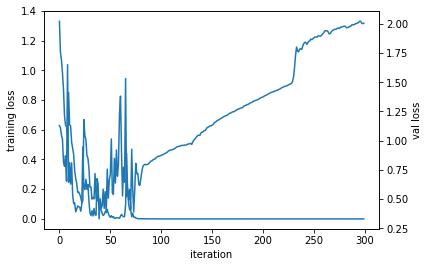

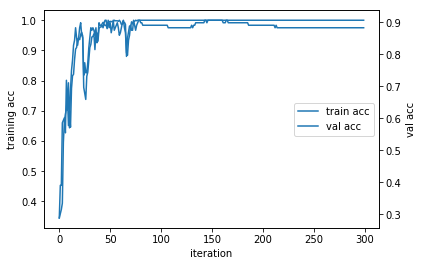

In [20]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
lns1=ax1.plot(np.arange(n_epoch),fig_loss1,label="Loss")
lns2=ax2.plot(np.arange(n_epoch),fig_loss2,label="Loss")
ax1.set_xlabel('iteration')
ax1.set_ylabel('training loss')
ax2.set_ylabel('val loss')
#训练和验证两种准确率曲线图放在一张图中
fig2,ax3=plt.subplots()
ax4=ax3.twinx()#由ax2图生成ax3图
lns3=ax3.plot(np.arange(n_epoch),fig_acc1,label="Loss")
lns4=ax4.plot(np.arange(n_epoch),fig_acc2,label="Loss")
ax3.set_xlabel('iteration')
ax3.set_ylabel('training acc')
ax4.set_ylabel('val acc')
#合并图例
lns5=lns1+lns2
labels1=["train loss","val loss"]
plt.legend(lns5,labels1,loc=7)
lns6=lns3+lns4
labels2=["train acc","val acc"]
plt.legend(lns6,labels2,loc=7)
plt.show()

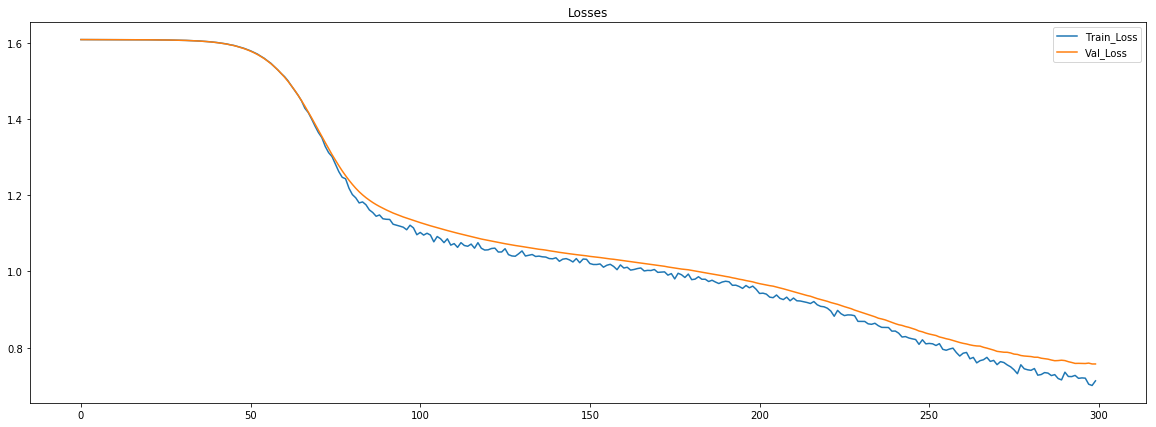

In [24]:
fig,ax1=plt.subplots(figsize=(20,7))
plt.plot(np.arange(n_epoch),fig_loss1,label="Train_Loss")
plt.plot(np.arange(n_epoch),fig_loss2,label="Val_Loss")
plt.title("Losses")
plt.legend()
plt.show()
# ax1.set_xlabel('iteration')
# ax1.set_ylabel('loss')
# #训练和验证两种准确率曲线图放在一张图中
# fig2,ax2=plt.subplots(figsize=(20,7))
# ax2.plot(np.arange(n_epoch),fig_acc1,label="Loss")
# ax2.plot(np.arange(n_epoch),fig_acc2,label="Loss")
# ax2.set_xlabel('iteration')
# ax2.set_ylabel('training acc')
# #合并图例
# lns5=lns1+lns2
# labels1=["train loss","val loss"]
# plt.legend(lns5,labels1,loc=7)
# lns6=lns3+lns4
# labels2=["train acc","val acc"]
# plt.legend(lns6,labels2,loc=7)
# plt.show()
#     losses=losses.append((t_loss+v_loss,t_loss,v_loss))
#     accuracy=accuracy.append((t_acc+v_acc,t_acc,v_acc))
#     fig, ax = plt.subplots(figsize=(20,7))
#     losses = np.array(losses)
#     plt.plot(losses.T[0], label='Discriminator Total Loss')
#     plt.plot(losses.T[1], label='Discriminator Train Loss')
#     plt.plot(losses.T[2], label='Discriminator Val Loss')
#     plt.title("Losses")
#     plt.legend()
#     fig, ax = plt.subplots(figsize=(20,7))
#     accuracy = np.array(accuracy)
#     plt.plot(losses.T[0], label='Discriminator Total Acc')
#     plt.plot(losses.T[1], label='Discriminator Train Acc')
#     plt.plot(losses.T[2], label='Discriminator Val Acc')
#     plt.title("Accuracy")
#     plt.legend()

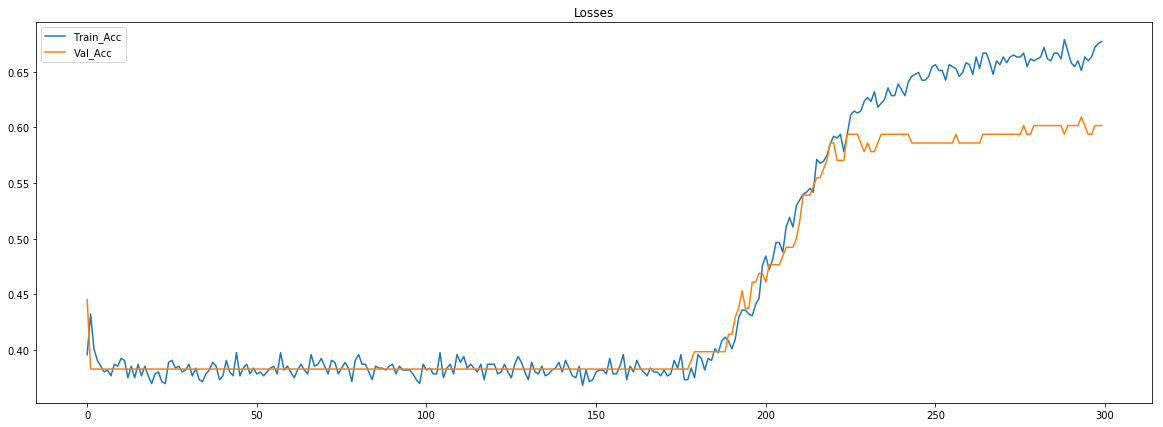

In [25]:
fig,ax2=plt.subplots(figsize=(20,7))
plt.plot(np.arange(n_epoch),fig_acc1,label="Train_Acc")
plt.plot(np.arange(n_epoch),fig_acc2,label="Val_Acc")
plt.title("Losses")
plt.legend()
plt.show()